In [2]:
#combine all summary stats for one mouse
%load_ext autoreload
%autoreload 2
 
#%matplotlib inline

In [3]:
import sys
sys.path.append('../../../src/')

import os
from typing import Dict
from os import PathLike
from pathlib import Path
import csv 

from aind_vr_foraging_analysis import utils
from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
import datetime

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle
from scipy.signal import find_peaks, butter, lfilter


colors = sns.color_palette()
odor_list_color = [colors[8], colors[0], colors[2], colors[4]]

pdf_path = r'/Volumes\scratch\vr-foraging\sessions'
base_path = r'/Volumes/scratch/vr-foraging/data/'
foraging_figures = r'/Users/nehal.ajmal/Documents/aindproject/analysis_files'

from scipy.optimize import curve_fit

In [4]:
# #exploring at home
# session_path = r'/Users/nehal.ajmal/Desktop/717716_20240719T093806'
# mouse = '717716'
# session = '20240719T093806'

In [5]:
#exploring at work
session_path = '/Volumes/aind/scratch/vr-foraging/data/745305/745305_20240726T083719'

#get mouse_id from first 6 numbers in file name
mouse = session_path.split('/')[-1][:6]

#get session from first 8 numbers after mouse_id
session = session_path.split('/')[-1][6:15]

In [6]:
session_path = Path(session_path)
data = parse.load_session_data(session_path)

# Parse data into a dataframe with the main features
reward_sites, active_site, config = parse.parse_dataframe(data)

In [7]:
# Expand with extra columns
reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
 # Add extra columns to the active_site dataframe
active_site = AddExtraColumns(reward_sites, active_site, run_on_init=False).add_time_previous_intersite_interpatch()

In [8]:
# Recover color palette
color_dict_label = {}
dict_odor = {}
list_patches = parse.TaskSchemaProperties(data).patches
for i, patches in enumerate(list_patches):
    color_dict_label[patches['label']] = odor_list_color[i]
    dict_odor[i] = patches['label']

In [9]:
# Load the encoder data separately
stream_data = parse.ContinuousData(data)
encoder_data = stream_data.encoder_data

# Plotting site duration


In [10]:
def plot_duration_by_site(data, x_col, y_col, hue_col, hue_order, palette, x_label, y_label, title, bbox_to_anchor=(1.05, 1), loc=2):
    """
    Plot duration of each reward site with the trial type / odor_label in color.

    Parameters:
    - data: DataFrame containing the data to plot.
    - x_col: The name of the column for the x-axis.
    - y_col: The name of the column for the y-axis.
    - hue_col: The name of the column for the hue.
    - hue_order: List of hue categories to order.
    - palette: Color palette for the plot.
    - x_label: Label for the x-axis.
    - y_label: Label for the y-axis.
    - title: Title of the plot.
    - bbox_to_anchor: Position of the legend.
    - loc: Location of the legend.
    """
    fig, ax = plt.subplots()
    ax = sns.scatterplot(data=data, x=x_col, y=y_col, hue=hue_col, hue_order=hue_order, ax=ax, palette=palette)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc)
    plt.show()

In [11]:
# #add extra columns to active_site
# active_site = AddExtraColumns(reward_sites, active_site, run_on_init=False).add_time_previous_intersite_interpatch()

# # reset the index to turn it into a column
# plot_df = active_site.reset_index()

# # shift the 'index' column by 1 position
# plot_df['next_site'] = plot_df['Seconds'].shift(-1)

# plot_df['time_spent'] = plot_df['next_site'] - plot_df['Seconds']
# plot_df = plot_df[plot_df['label'] == 'RewardSite']

In [12]:
active_site['next_intersite'] = active_site.index.to_series().shift(-1)
reward_sites = active_site.loc[active_site['label']=='RewardSite']
reward_sites['time_in_odor_site'] = reward_sites.next_intersite - reward_sites.index

#make plot_df 
plot_df = reward_sites[['time_in_odor_site', 'odor_label', 'active_patch']]

In [13]:
plot_df

,time_in_odor_site,odor_label,active_patch
Seconds,,,
1.001535e+07,1.242016,NULL,0.0
1.001536e+07,1.042016,NULL,1.0
1.001536e+07,1.484000,ODOR_A,2.0
1.001537e+07,1.233984,ODOR_A,3.0
1.001537e+07,1.059008,NULL,4.0
...,...,...,...
1.001738e+07,1.982016,NULL,196.0
1.001740e+07,1.260000,ODOR_C,197.0
1.001743e+07,1.600000,NULL,198.0


In [14]:
# # #remove outlier
# plot_df = plot_df[plot_df['time_spent'] < 15]

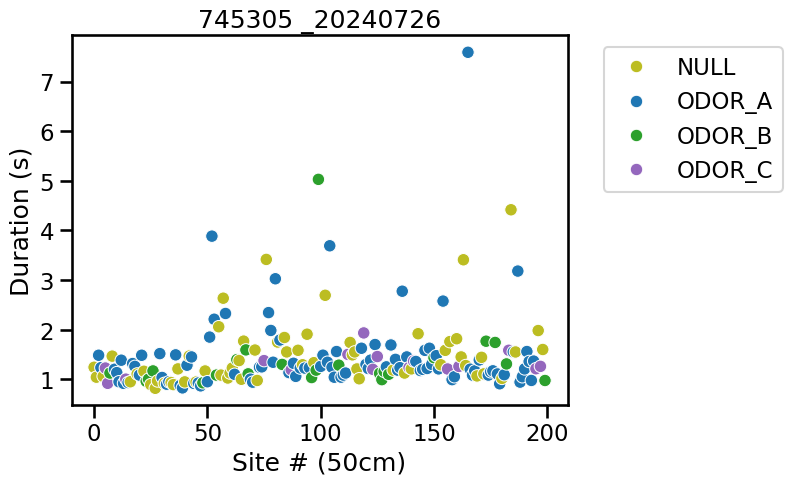

In [15]:
# plot duration of each reward site, with the trial type / odor_label in color
plot_duration_by_site(
    data=plot_df,
    x_col='active_patch',
    y_col='time_in_odor_site',
    hue_col='odor_label',
    hue_order=np.sort(plot_df['odor_label'].unique()),
    palette=odor_list_color,
    x_label='Site # (50cm)',
    y_label='Duration (s)',
    title=f'{mouse} {session}'
)

# Breathing Signal for a Site


In [16]:
#merge dictionaries for intersites and sites
label_dict = {**{
    "InterSite": '#808080',
    "InterPatch": '#b3b3b3'}, 
              **color_dict_label}


In [17]:
#make df for plotting breathing sniffs
trial_summary = plotting.trial_collection(reward_sites[['has_choice', 'visit_number', 'odor_label', 'odor_sites', 'time_in_odor_site']], stream_data.breathing, mouse, session, window=(-2,8), taken_col='data')

In [18]:
def plot_sniff(total_site):
    align = None
    # Plot the signal
    fig, ax = plt.subplots(1,1, figsize= (8,6), sharex=True)
 
    color = color_dict_label[trial_summary.odor_label.unique()[0]]
    total_sites_df = trial_summary.loc[trial_summary.odor_sites == total_site]
    time = total_sites_df['times']
    signal = total_sites_df['data']
    max_signal = max(trial_summary.data.values)
    min_signal = min(trial_summary.data.values)


    # calculate the end time of the odor site and the new x-axis limits
    odor_end_time = total_sites_df.time_in_odor_site.unique()[0]
    x_start = -2
    x_end = odor_end_time + 0.5  # extend 1 second past the end time of the odor site
    
    # Plot the signal
    ax.plot(time, signal, color='black')
    ax.set_title(f'Stop: {total_sites_df.has_choice.unique()[0]} Odor: {total_sites_df.odor_label.unique()[0]}  Odor site: {total_sites_df.odor_sites.unique()[0]}')
    ax.set_ylabel('Amplitude (a.u.)')
    ax.vlines(0, min_signal, max_signal, color='black', linestyles = ':')

    if align == 'odor_onset':
        ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), 0, total_sites_df['odor_offset'].unique(), color=color, alpha=.5, linewidth=0)
    else:
        # ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), total_sites_df['odor_onset'].unique(), 0, color=color, alpha=.5, linewidth=0)
        ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), 0, total_sites_df.time_in_odor_site.unique()[0], color=color, alpha=.5, linewidth=0)

    # Set plot limits and labels
    ax.set_xlabel('Time (s)')
    ax.set_xlim(x_start, x_end) 
    sns.despine()
    plt.show()

def on_left_button_clicked(button):
    x_start_widget.value -= 1

def on_right_button_clicked(button):
    x_start_widget.value += 1

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='Site:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(plot_sniff, {'total_site': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)
 

Output()

# Breathing

In [19]:
# breathing data 
breathing = stream_data.breathing

# # Clean up data (remove NaNs, duplicate indices, etc.)
breathing = breathing.dropna()
breathing = breathing[~breathing.index.duplicated(keep='first')]
breathing = breathing.sort_index()

breathing_data = breathing.values.squeeze()

# Find peaks in the breathing signal using Tiffany's function
peaks = find_peaks(breathing_data, width = 5,  prominence=0.1)[0]

# Find troughs in the breathing signal
troughs = find_peaks(-breathing_data, height=0, width=3, prominence=0.1)[0]

# Ensure troughs are below the corresponding peak
troughs = troughs[troughs > peaks[0]]  # first trough after the first peak


In [20]:
#check length of peaks and troughs
len(peaks), len(troughs)

(15893, 16106)

In [21]:
# get timestamps corresponding to the peaks and troughs
peak_times = breathing.index[peaks]
trough_times = breathing.index[troughs]

In [22]:
#function to plot peaks and troughs
def peak_plot(x_start=None, x_end=None, window_duration=10):
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # default to the entire range if no specific x_start or x_end is given
    if x_start is None:
        x_start = breathing.index.min()
    if x_end is None:
        x_end = breathing.index.max()
    
    # calculate the center of the window based on x_start and x_end
    center_time = (x_start + x_end) / 2

    # adjust the x_start and x_end to show a 10-second window
    x_start = max(center_time - window_duration / 2, breathing.index.min())
    x_end = min(center_time + window_duration / 2, breathing.index.max())
    ax.grid(True)

     # Plot the breathing data
    ax.plot(breathing.index, breathing_data, label='Breathing Signal', color='black', linewidth=1)

    # plot peaks
    ax.scatter(peak_times, breathing_data[peaks], color='red', marker='o', label='Peaks')

    # plot troughs
    ax.scatter(trough_times, breathing_data[troughs], color='blue', marker='x', label='Troughs')

    # Aad labels, title, and legend
    ax.set_xlabel('Time')
    ax.set_ylabel('Breathing Signal')
    ax.set_title(f'Breathing Signal with Peaks and Troughs for {mouse} {session}')
    ax.legend()
    ax.set_xlim([x_start, x_end])
    
    plt.show()

In [23]:
# define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 10
    x_end_widget.value -= 10

def on_right_button_clicked(button):
    x_start_widget.value += 10
    x_end_widget.value += 10

# create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# define widgets for the x-axis range
x_start_widget = widgets.FloatText(value=breathing.index.min(), description='X start:', continuous_update=False)
x_end_widget = widgets.FloatText(value=breathing.index.max(), description='X end:', continuous_update=False)

# set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# arrange the buttons and widgets horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget, x_end_widget])

# create interactive plot
interactive_plot = widgets.interactive_output(peak_plot, {'x_start': x_start_widget, 'x_end': x_end_widget})

In [24]:
#interactive plot
display(ui, interactive_plot)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 2000x600 with 1 Axes>', '…

# Plot Breathing with Peaks, and Running overlayed

In [25]:
#plotting peaks and troughs with breathing signal
def update_plot(x_start):
    zero_index = active_site.index[0]

    fig, axs = plt.subplots(2, 1, figsize=(20, 8), gridspec_kw={'height_ratios': [2, 2]}, sharex=True)

    # Plot event patches
    _legend = {}
    for idx, site in enumerate(active_site.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index'] + 1}"
            facecolor = label_dict[site_label]
        elif site_label == "RewardSite":
            site_label = site[1]['odor_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx + 1] - active_site.index[idx], 8,
            linewidth=0, facecolor=facecolor, alpha=0.5)

        _legend[site_label] = p
        axs[0].add_patch(p)

        q = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx + 1] - active_site.index[idx], 8,
            linewidth=0, facecolor=facecolor, alpha=0.5)
        _legend[site_label] = q
        axs[1].add_patch(q)

    s, lw = 400, 2

    # Plot Choice Tone, Lick, and Reward
    y_idx = -0.4
    _legend["Choice Tone"] = axs[1].scatter(stream_data.choice_feedback.index - zero_index + 0.2,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs[1].scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs[1].scatter(stream_data.give_reward.index - zero_index,
            stream_data.give_reward.index * 0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")

    y_idx += 1

    axs[1].set_yticklabels([])
    axs[1].set_xlabel("Time(s)")
    axs[1].set_ylim(bottom=-1, top=3)
    axs[1].grid(False)

    # Breathing plot with peaks and troughs
    ax3 = axs[0].twinx()
    breathing_data = stream_data.breathing.values.squeeze()
    peaks = find_peaks(breathing_data, width=5, prominence=0.1)[0]
    troughs = find_peaks(-breathing_data, height=0, width=3, prominence=0.1)[0]
    troughs = troughs[troughs > peaks[0]]  # Filter out invalid troughs

    peak_times = stream_data.breathing.index[peaks]
    trough_times = stream_data.breathing.index[troughs]

    _legend["Breathing"] = ax3.plot(stream_data.breathing.index - zero_index, breathing_data, c="black", label="Breathing", alpha=0.8)[0]
    ax3.scatter(peak_times - zero_index, breathing_data[peaks], color='red', marker='o', label='Peaks')
    ax3.scatter(trough_times - zero_index, breathing_data[troughs], color='blue', marker='x', label='Troughs')

    ax3.grid(False)
    ax3.set_ylim(stream_data.breathing.mean()[0] - 400, stream_data.breathing.mean()[0] + 400)
    ax3.set_ylabel("Breathing (au)")

    # Plot velocity (running data) on the bottom subplot
    ax2 = axs[1].twinx()
    _legend["Velocity"] = ax2.plot(encoder_data.index - zero_index, encoder_data.filtered_velocity, c="k", label="Encoder", alpha=0.8)[0]
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha=0.5, lw=2, ls="--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")

    axs[0].legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.08, 0.1), loc='center left', borderaxespad=0.)

    for i in [0, 1]:
        axs[i].set_xlabel("Time(s)")
        axs[i].grid(False)
        axs[i].set_ylim(bottom=-1, top=4)
        axs[i].set_yticks([])
        axs[i].yaxis.tick_right()
        axs[i].set_xlim([x_start, x_start + 5])

# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 5

def on_right_button_clicked(button):
    x_start_widget.value += 5

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=0.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

Output()

# trying to get peaks and troughs for each odor site

In [26]:
# identify peaks and troughs
def identify_peaks_and_troughs(data, width_peaks=5, prominence_peaks=0.1, width_troughs=3, prominence_troughs=0.1):
    """
    Identify peaks and troughs in the given data.
    
    Parameters:
    - data: The data array to analyze, typically used w sniff data.
    - width_peaks: Minimum width of peaks.
    - prominence_peaks: Minimum prominence of peaks.
    - width_troughs: Minimum width of troughs.
    - prominence_troughs: Minimum prominence of troughs.
    
    Returns:
    - peak_times: Timestamps of peaks.
    - trough_times: Timestamps of troughs.
    """
    # Clean up data (remove NaNs, duplicate indices, etc.)
    data = data.dropna()
    data = data[~data.index.duplicated(keep='first')]
    data = data.sort_index()

    # Convert to numpy array
    data_values = data.values.squeeze()

    # Find peaks
    peaks, _ = find_peaks(data_values, width=width_peaks, prominence=prominence_peaks)
    
    # Find troughs
    troughs, _ = find_peaks(-data_values, width=width_troughs, prominence=prominence_troughs)
    
    # Ensure troughs are below the corresponding peaks
    troughs = troughs[troughs > peaks[0]]  # First trough after the first peak

    # Get timestamps corresponding to the peaks and troughs
    peak_times = data.index[peaks]
    trough_times = data.index[troughs]

    return peak_times, trough_times


In [27]:
peak_times, trough_times = identify_peaks_and_troughs(stream_data.breathing, width_peaks=5, prominence_peaks=0.1, width_troughs=3, prominence_troughs=0.1)


In [28]:
# Update the plot_sniff functionn to include peaks and troughs
def plot_sniff(total_site):
    align = None
    # Prepare figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
    
    # Select data for the given total_site
    total_sites_df = trial_summary.loc[trial_summary.odor_sites == total_site]
    
    # Calculate the end time of the odor site and the new x-axis limits
    odor_end_time = total_sites_df.time_in_odor_site.unique()[0]
    x_start = -2
    x_end = odor_end_time + 0.5  # Extend 0.5 seconds past the end time of the odor site

    # Get relevant data
    time = total_sites_df['times']
    signal = total_sites_df['data']
    odor_label = total_sites_df.odor_label.unique()[0]
    odor_color = color_dict_label.get(odor_label, 'gray')  # Default to gray if label not found
    max_signal = max(trial_summary.data.values)
    min_signal = min(trial_summary.data.values)

    # identify peaks and troughs in the signal data
    peak_times, trough_times = identify_peaks_and_troughs(total_sites_df.set_index('times')['data'])

    # Plot the signal
    ax.plot(time, signal, color='black', label='Signal')
    ax.set_title(f'Odor: {odor_label}  Odor site: {total_sites_df.odor_sites.unique()[0]}')
    ax.set_ylabel('Amplitude (a.u.)')
    ax.vlines(0, min_signal, max_signal, color='black', linestyles=':')

    # Shade the region based on odor label
    if align == 'odor_onset':
        ax.fill_betweenx(np.arange(min_signal, max_signal, 0.1),
                         0, total_sites_df['odor_offset'].unique(),
                         color=odor_color, alpha=.5, linewidth=0)
    else:
        ax.fill_betweenx(np.arange(min_signal, max_signal, 0.1),
                         0, total_sites_df.time_in_odor_site.unique()[0],
                         color=odor_color, alpha=.5, linewidth=0)

    # Plot peaks and troughs
    ax.scatter(peak_times, total_sites_df.set_index('times')['data'].loc[peak_times], color='red', marker='o', label='Peaks')
    ax.scatter(trough_times, total_sites_df.set_index('times')['data'].loc[trough_times], color='blue', marker='x', label='Troughs')

    # Set plot limits and labels
    ax.set_xlabel('Time (s)')
    ax.set_xlim(x_start, x_end) 
    ax.legend()
    sns.despine()
    plt.show()

# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 1

def on_right_button_clicked(button):
    x_start_widget.value += 1

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=0.0, description='Site:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(plot_sniff, {'total_site': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)


Output()

# instantaneous sniff rate

In [29]:
trial_summary

,times,data,has_choice,visit_number,odor_label,odor_sites,time_in_odor_site,mouse,session
0,-2.000,2662,False,0.0,NULL,0.0,1.242016,745305,_20240726
1,-1.996,2677,False,0.0,NULL,0.0,1.242016,745305,_20240726
2,-1.992,2680,False,0.0,NULL,0.0,1.242016,745305,_20240726
3,-1.988,2498,False,0.0,NULL,0.0,1.242016,745305,_20240726
4,-1.984,2313,False,0.0,NULL,0.0,1.242016,745305,_20240726
...,...,...,...,...,...,...,...,...,...
499995,7.980,2234,False,0.0,ODOR_B,199.0,0.974976,745305,_20240726
499996,7.984,2241,False,0.0,ODOR_B,199.0,0.974976,745305,_20240726
499997,7.988,2274,False,0.0,ODOR_B,199.0,0.974976,745305,_20240726
499998,7.992,2274,False,0.0,ODOR_B,199.0,0.974976,745305,_20240726


In [30]:
# initialize lists to store peaks data and sniff rates data
peaks_data = []
sniff_rates_data = []

# iterate through each unique odor label
for odor_label in trial_summary['odor_label'].unique():
    # filter data for the given odor label
    odor_df = trial_summary[trial_summary['odor_label'] == odor_label]
     
    for site in odor_df['odor_sites'].unique():
        site_df = odor_df[odor_df['odor_sites'] == site]
    
        # get relevant signal data
        signal = site_df.set_index('times')['data']
        
        # get the end time of the odor site
        odor_end_time = odor_df['time_in_odor_site'].unique()[0]

        # define the time limits for peak detection
        x_start = 0
        x_end = odor_end_time
        
        # filter the signal based on time limits
        filtered_signal = signal[(signal.index >= x_start) & (signal.index <= x_end)]
        
        if filtered_signal.empty:
            continue  # Skip if no data within the defined time range
        
        # identify peaks
        peak_times, _ = find_peaks(filtered_signal, width=5, prominence=0.1)
        
        if len(peak_times) > 0:
            # get the time indices of peaks
            peak_times_indices = filtered_signal.index[peak_times]
            
            # calculate the peak count
            peak_count = len(peak_times_indices)
            
            # calculate the time duration of the epoch
            epoch_duration = x_end - x_start

            # calculate peak frequency (peaks per second)
            if epoch_duration > 0:
                peak_frequency = peak_count / epoch_duration
            else:
                peak_frequency = 0

            # store peak frequency data
            peaks_data.append({
                'odor_label': odor_label, 
                'odor_site': site, 
                'peak_count': peak_count,
                'peak_frequency': peak_frequency,
                'epoch_duration': epoch_duration
            })
            
            # calculate inter-sniff intervals and instantaneous sniff rates
            if len(peak_times_indices) > 1:
                # calculate inter-sniff intervals (time differences between successive peaks)
                inter_sniff_intervals = np.diff(peak_times_indices)
                
                # calculate instantaneous sniff rates (sniffs per second)
                instantaneous_sniff_rates = 1 / inter_sniff_intervals  # sniffs per second

                # store the sniff rates data
                for idx, rate in enumerate(instantaneous_sniff_rates):
                    sniff_rates_data.append({
                        'odor_label': odor_label,
                        'odor_site': site,
                        'peak_time': peak_times_indices[idx + 1],  # Time of the second peak
                        'inter_sniff_interval': inter_sniff_intervals[idx],
                        'instantaneous_sniff_rate': rate
                    })
                
# create DataFrame from the collected peaks data
peaks_df = pd.DataFrame(peaks_data)

# create DataFrame from the collected sniff rates data
sniff_rates_df = pd.DataFrame(sniff_rates_data)

# print the DataFrame to check the data
print(peaks_df)

# print the sniff rates data
print(sniff_rates_df)


    odor_label  odor_site  peak_count  peak_frequency  epoch_duration
0         NULL        0.0          12        9.661711        1.242016
1         NULL        1.0          10        8.051426        1.242016
2         NULL        4.0          11        8.856569        1.242016
3         NULL        8.0          11        8.856569        1.242016
4         NULL       16.0          10        8.051426        1.242016
..         ...        ...         ...             ...             ...
195     ODOR_B      150.0           8        7.111162        1.124992
196     ODOR_B      173.0           9        8.000057        1.124992
197     ODOR_B      177.0           9        8.000057        1.124992
198     ODOR_B      182.0           7        6.222266        1.124992
199     ODOR_B      199.0           8        7.111162        1.124992

[200 rows x 5 columns]
     odor_label  odor_site  peak_time  inter_sniff_interval  \
0          NULL        0.0      0.172                 0.120   
1         

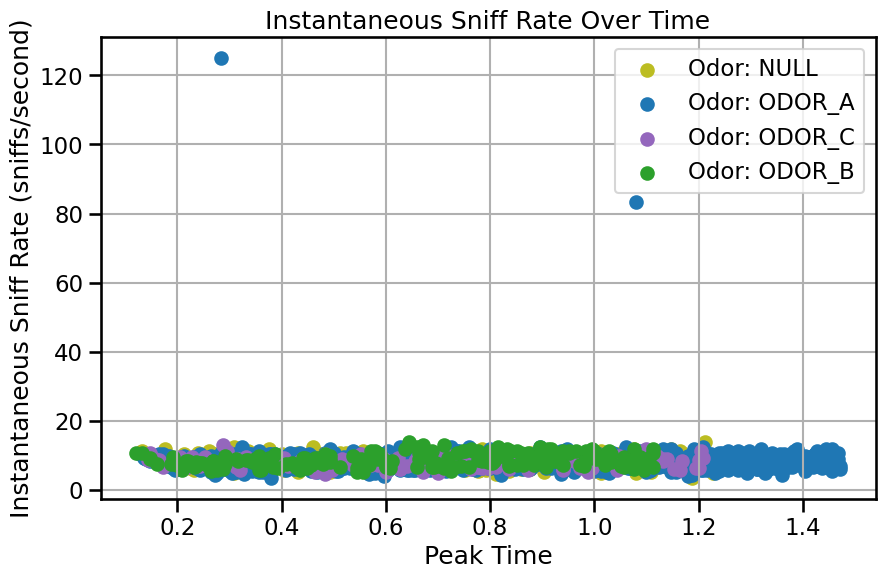

In [31]:
#plot the instantaneous sniff rate
fig, ax = plt.subplots(figsize=(10, 6))

# plot instantaneous sniff rate for each odor label and site
for odor_label in sniff_rates_df['odor_label'].unique():
    subset = sniff_rates_df[sniff_rates_df['odor_label'] == odor_label]
    ax.scatter(subset['peak_time'], subset['instantaneous_sniff_rate'], color = color_dict_label[odor_label], label=f'Odor: {odor_label}')

ax.set_xlabel('Peak Time')
ax.set_ylabel('Instantaneous Sniff Rate (sniffs/second)')
ax.set_title('Instantaneous Sniff Rate Over Time')
ax.legend()
ax.grid(True)

plt.show()

In [32]:
from scipy.stats import zscore
# remove outliers using Z-score for peak frequency and instantaneous sniff rate
def remove_outliers(df, column_name):
    """Remove outliers based on Z-score."""
    df = df.copy()  
    df['z_score'] = zscore(df[column_name])
    return df[df['z_score'].abs() <= 4].drop(columns='z_score')  

# Remove outliers from peaks_df
peaks_df_clean = remove_outliers(peaks_df, 'peak_frequency')

# Remove outliers from sniff_rates_df
sniff_rates_df_clean = remove_outliers(sniff_rates_df, 'instantaneous_sniff_rate')

# Print the cleaned DataFrames to check the data
print(peaks_df_clean)
print(sniff_rates_df_clean)

    odor_label  odor_site  peak_count  peak_frequency  epoch_duration
0         NULL        0.0          12        9.661711        1.242016
1         NULL        1.0          10        8.051426        1.242016
2         NULL        4.0          11        8.856569        1.242016
3         NULL        8.0          11        8.856569        1.242016
4         NULL       16.0          10        8.051426        1.242016
..         ...        ...         ...             ...             ...
195     ODOR_B      150.0           8        7.111162        1.124992
196     ODOR_B      173.0           9        8.000057        1.124992
197     ODOR_B      177.0           9        8.000057        1.124992
198     ODOR_B      182.0           7        6.222266        1.124992
199     ODOR_B      199.0           8        7.111162        1.124992

[200 rows x 5 columns]
     odor_label  odor_site  peak_time  inter_sniff_interval  \
0          NULL        0.0      0.172                 0.120   
1         

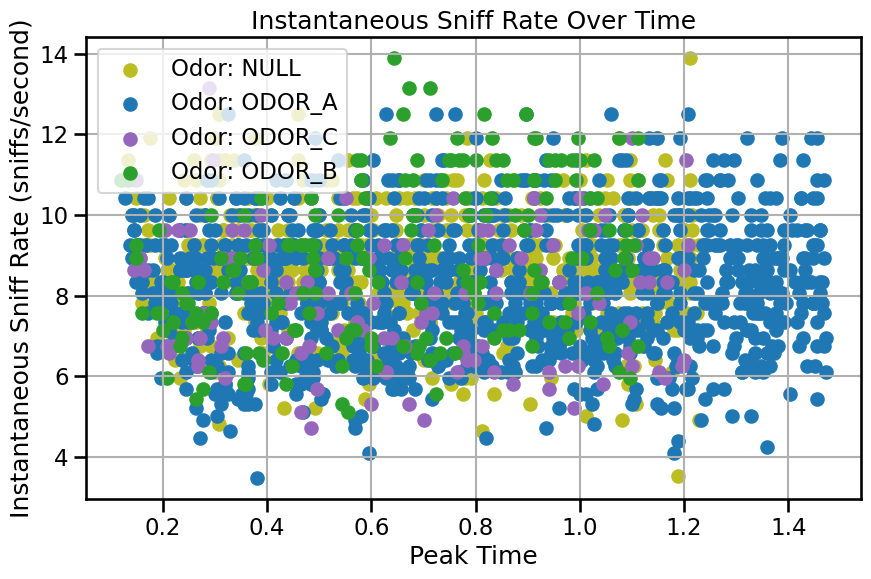

In [33]:
#plot the instantaneous sniff rate
fig, ax = plt.subplots(figsize=(10, 6))

# plot instantaneous sniff rate for each odor label and site
for odor_label in sniff_rates_df_clean['odor_label'].unique():
    subset = sniff_rates_df_clean[sniff_rates_df_clean['odor_label'] == odor_label]
    ax.scatter(subset['peak_time'], subset['instantaneous_sniff_rate'], color = color_dict_label[odor_label], label=f'Odor: {odor_label}')

ax.set_xlabel('Peak Time')
ax.set_ylabel('Instantaneous Sniff Rate (sniffs/second)')
ax.set_title('Instantaneous Sniff Rate Over Time')
ax.legend()
ax.grid(True)

plt.show()


# average peaks per odor site

In [34]:
# group by odor label and calculate the average number of peaks
average_peaks_df = peaks_df.groupby('odor_label')['peak_count'].mean().reset_index()
average_peaks_df.columns = ['odor_label', 'average_peak_count']
print(average_peaks_df)

  odor_label  average_peak_count
0       NULL           10.129032
1     ODOR_A           11.292929
2     ODOR_B            9.260870
3     ODOR_C            9.187500


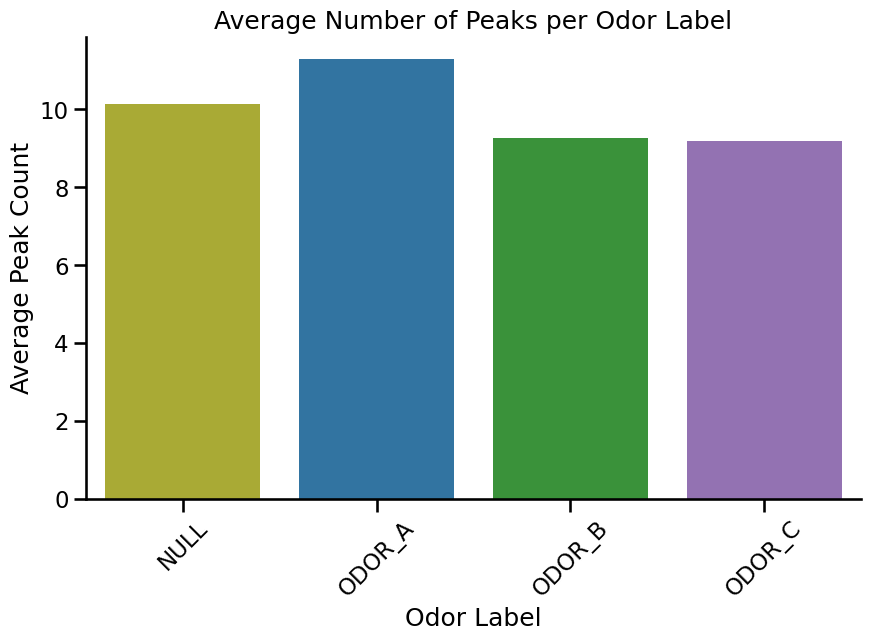

In [35]:
# Plot the average number of peaks for each odor label
plt.figure(figsize=(10, 6))
sns.barplot(x='odor_label', y='average_peak_count', data=average_peaks_df, palette=odor_list_color)
plt.xlabel('Odor Label')
plt.ylabel('Average Peak Count')
plt.title('Average Number of Peaks per Odor Label')
plt.xticks(rotation=45)
sns.despine()
plt.show()



In [36]:
trial_summary

,times,data,has_choice,visit_number,odor_label,odor_sites,time_in_odor_site,mouse,session
0,-2.000,2662,False,0.0,NULL,0.0,1.242016,745305,_20240726
1,-1.996,2677,False,0.0,NULL,0.0,1.242016,745305,_20240726
2,-1.992,2680,False,0.0,NULL,0.0,1.242016,745305,_20240726
3,-1.988,2498,False,0.0,NULL,0.0,1.242016,745305,_20240726
4,-1.984,2313,False,0.0,NULL,0.0,1.242016,745305,_20240726
...,...,...,...,...,...,...,...,...,...
499995,7.980,2234,False,0.0,ODOR_B,199.0,0.974976,745305,_20240726
499996,7.984,2241,False,0.0,ODOR_B,199.0,0.974976,745305,_20240726
499997,7.988,2274,False,0.0,ODOR_B,199.0,0.974976,745305,_20240726
499998,7.992,2274,False,0.0,ODOR_B,199.0,0.974976,745305,_20240726


# velocity traces for session

In [37]:
import seaborn as sns


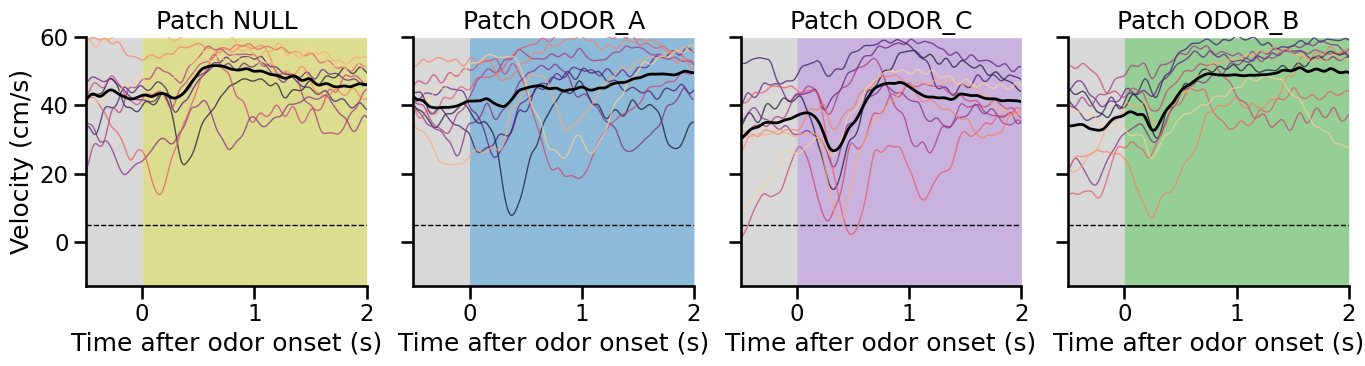

In [41]:
#plot velocity trace for one animal, first 10 sites
trial_summary_running= plotting.trial_collection(reward_sites[[ 'visit_number', 'odor_label','odor_sites']], encoder_data, mouse, session, window=(-2,4))
trial_summary_running.loc[(trial_summary_running.odor_label == 'NULL')].odor_sites.unique()
max_range=max(trial_summary_running.speed.values)
plotting.velocity_traces_odor_entry(trial_summary_running, 
                                    color_dict_label=color_dict_label, cmap = 'magma', 
                                    mean=True, save=False)

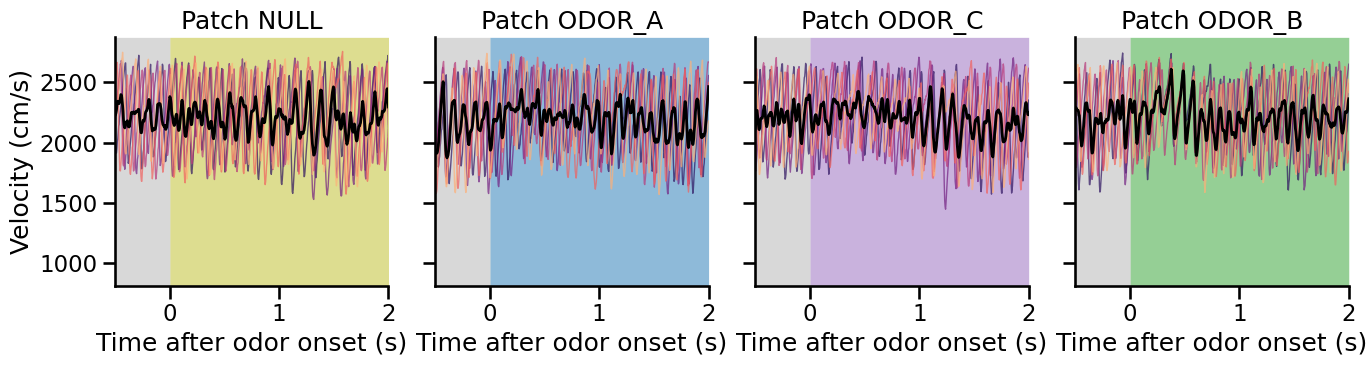

In [42]:
#make df for plotting breathing sniffs
trial_summary_breathing = plotting.trial_collection(reward_sites[['has_choice', 'visit_number', 'odor_label', 'odor_sites', 'time_in_odor_site']], stream_data.breathing, mouse, session, window=(-2,8), taken_col='data')
trial_summary_breathing.loc[(trial_summary_breathing.odor_label == 'NULL')].odor_sites.unique()
y_max = trial_summary_breathing.data.max()
y_min = trial_summary_breathing.data.min()
plotting.velocity_traces_odor_entry(trial_summary_breathing, y_lims = (y_min, y_max),
                                    color_dict_label=color_dict_label, cmap = 'magma', 
                                    mean=True, save=False,  y = 'data', n_sites = 5)

### get sniff peak times rasterplot

In [43]:
peak_times, trough_times = identify_peaks_and_troughs(stream_data.breathing, width_peaks=5, prominence_peaks=0.1, width_troughs=3, prominence_troughs=0.1)

In [44]:
tmp = stream_data.breathing.reset_index()
peak_time_indices = tmp[tmp['Time'].isin(peak_times)].index.values

In [45]:
# create array of zeros that is the length of the full breathing timeseries
sniff_timestamps = stream_data.breathing.index
peaks_timeseries = np.zeros(len(sniff_timestamps))
# set all indices where a sniff peak occured to 1
peaks_timeseries[peak_time_indices] = 1
print(len(sniff_timestamps), len(peaks_timeseries))


528534 528534


(10000.0, 10700.0)

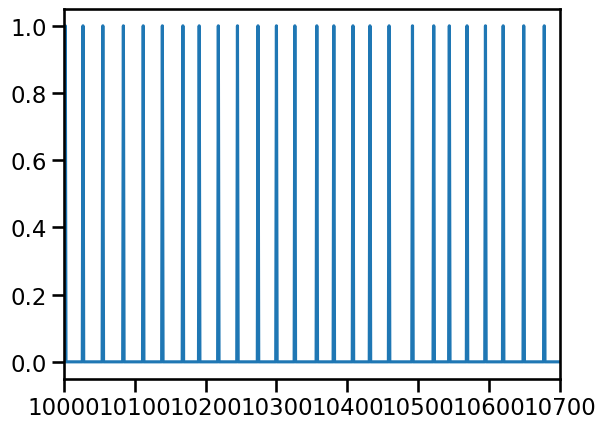

In [46]:
plt.plot(peaks_timeseries)
plt.xlim(10000, 10700)

In [47]:
# turn it into a dataframe with timestamps & peak binary / boolean (zero or 1)
peaks_df = pd.DataFrame(index=stream_data.breathing.index, data=peaks_timeseries, columns=['peaks'])
peaks_df.head()


,peaks
Time,
1.001534e+07,0.0
1.001534e+07,0.0
1.001534e+07,0.0
1.001534e+07,0.0
1.001534e+07,0.0


In [59]:
# align to trial starts
trial_summary_peaks = plotting.trial_collection(reward_sites[['has_choice', 'visit_number', 'odor_label', 'odor_sites', 'time_in_odor_site']], 
                                                    peaks_df, mouse, session, 
                                                    window=(-2,8), taken_col='peaks')


In [60]:
trial_summary_peaks

,times,peaks,has_choice,visit_number,odor_label,odor_sites,time_in_odor_site,mouse,session
0,-2.000,0.0,False,0.0,NULL,0.0,1.242016,745305,_20240726
1,-1.996,0.0,False,0.0,NULL,0.0,1.242016,745305,_20240726
2,-1.992,1.0,False,0.0,NULL,0.0,1.242016,745305,_20240726
3,-1.988,0.0,False,0.0,NULL,0.0,1.242016,745305,_20240726
4,-1.984,0.0,False,0.0,NULL,0.0,1.242016,745305,_20240726
...,...,...,...,...,...,...,...,...,...
499995,7.980,0.0,False,0.0,ODOR_B,199.0,0.974976,745305,_20240726
499996,7.984,0.0,False,0.0,ODOR_B,199.0,0.974976,745305,_20240726
499997,7.988,0.0,False,0.0,ODOR_B,199.0,0.974976,745305,_20240726
499998,7.992,0.0,False,0.0,ODOR_B,199.0,0.974976,745305,_20240726


In [115]:
# pivot so that columns are times and rows are sites, keeping site # and odor label as index, with peak binary as values
sniff_raster = pd.pivot_table(data=trial_summary_peaks, index=['odor_label', 'odor_sites'], columns=['times'], values='peaks')
sniff_raster

times                  -2.000  -1.996  -1.992  -1.988  -1.984  -1.980  -1.976  \
odor_label odor_sites                                                           
NULL       0.0            0.0     0.0     1.0     0.0     0.0     0.0     0.0   
           1.0            0.0     0.0     0.0     0.0     0.0     0.0     0.0   
           4.0            0.0     0.0     0.0     0.0     0.0     0.0     0.0   
           8.0            0.0     0.0     0.0     0.0     0.0     0.0     0.0   
           16.0           0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...                       ...     ...     ...     ...     ...     ...     ...   
ODOR_C     156.0          0.0     0.0     0.0     1.0     0.0     0.0     0.0   
           161.0          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
           183.0          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
           195.0          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
           197.0          0.0     0.0     0.0     0.0     0.0     1.0     0.0   

times                  -1.972  -1.968  -1.964  ...   7.960   7.964   7.968  \
odor_label odor_sites                          ...                           
NULL       0.0            0.0     0.0     0.0  ...     0.0     0.0     0.0   
           1.0            0.0     0.0     0.0  ...     0.0     0.0     0.0   
           4.0            0.0     0.0     0.0  ...     0.0     0.0     0.0   
           8.0            0.0     0.0     0.0  ...     0.0     0.0     0.0   
           16.0           0.0     0.0     0.0  ...     0.0     0.0     0.0   
...                       ...     ...     ...  ...     ...     ...     ...   
ODOR_C     156.0          0.0     0.0     0.0  ...     0.0     0.0     0.0   
           161.0          0.0     0.0     0.0  ...     0.0     0.0     0.0   
           183.0          0.0     0.0     0.0  ...     0.0     0.0     0.0   
           195.0          0.0     0.0     0.0  ...     0.0     0.0     0.0   
           197.0          0.0     0.0     0.0  ...     0.0     0.0     0.0   

times                   7.972   7.976   7.980   7.984   7.988   7.992   7.996  
odor_label odor_sites                                                          
NULL       0.0            0.0     0.0     0.0     0.0     0.0     0.0     0.0  
           1.0            0.0     0.0     0.0     0.0     0.0     0.0     0.0  
           4.0            0.0     0.0     0.0     0.0     0.0     0.0     0.0  
           8.0            0.0     0.0     0.0     0.0     0.0     0.0     0.0  
           16.0           1.0     0.0     0.0     0.0     0.0     0.0     0.0  
...                       ...     ...     ...     ...     ...     ...     ...  
ODOR_C     156.0          0.0     0.0     0.0     0.0     0.0     0.0     0.0  
           161.0          0.0     0.0     0.0     0.0     0.0     0.0     0.0  
           183.0          0.0     0.0     0.0     0.0     0.0     0.0     0.0  
           195.0          0.0     0.0     0.0     0.0     0.0     1.0     0.0  
           197.0          0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[200 rows x 2500 columns]

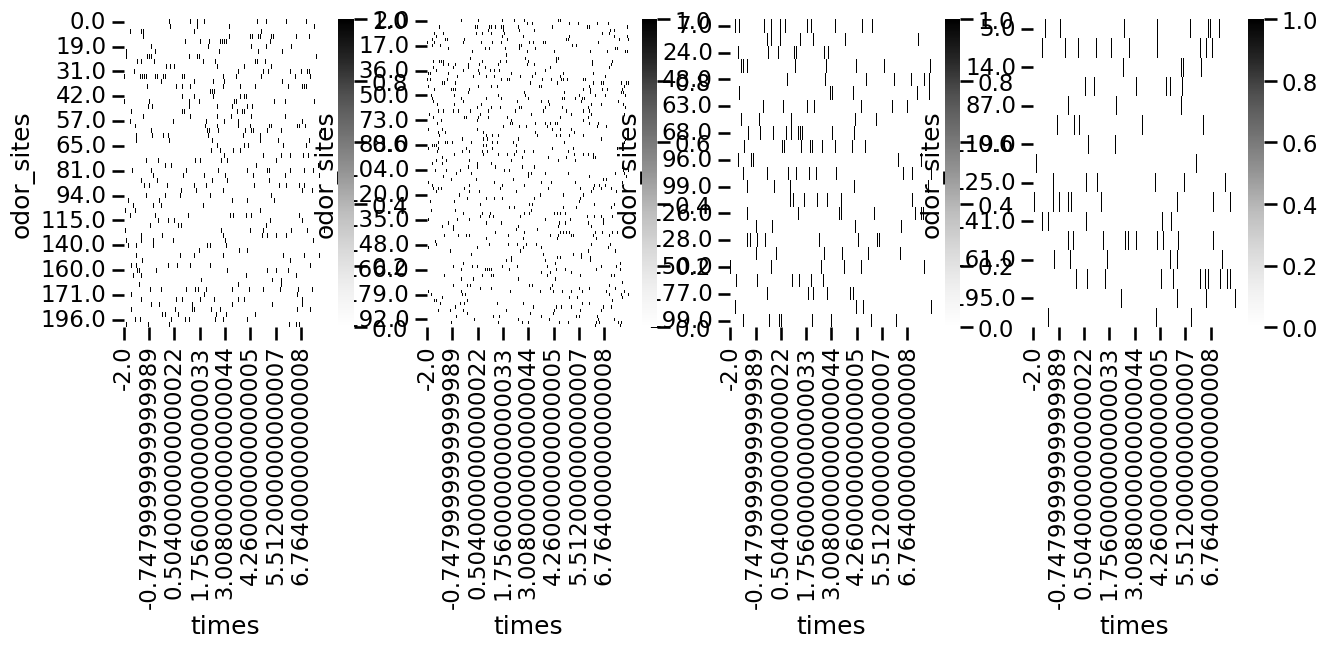

In [116]:
# get each odor label from the index of our dataframe
odor_labels = sniff_raster.index.get_level_values(0).unique()
# plot each odor on its own axis
figsize = (15,4)
fig, ax = plt.subplots(1,4, figsize=figsize)
for i, odor_label in enumerate(odor_labels):
    # data for each odor is the sniff peaks over time within each trial
    data = sniff_raster.loc[(odor_label)] 
    # plot it with a gray heatmap so that the zeros are white and the peak times (ones) are black
    ax[i] = sns.heatmap(data=data, cmap='Greys', ax=ax[i])

Note that the y axis for each odor differs. There are different numbers of trials for each odor and the indices of the odor sites are different. So you cant align the rows here. Let's change the y axis values so that it just shows the overall number of sites / trials for each odor.

Text(0.5, 1.1, 'Sniff times relative to odor onset')

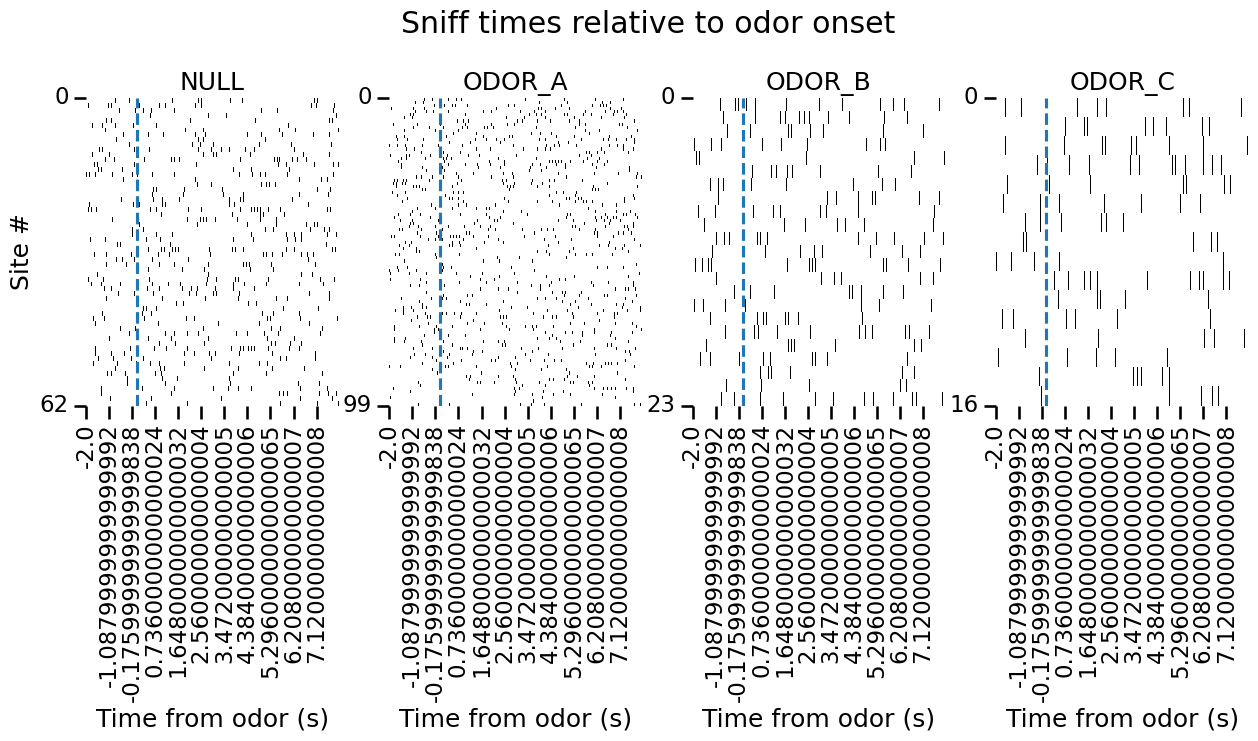

In [142]:
odor_labels = sniff_raster.index.get_level_values(0).unique()

# get timestamps & xticks for labeling plot
timestamps = sniff_raster.columns
acquisition_rate = 1/np.mean(peaks_df.index.diff().dropna())
xticks = np.arange(timestamps[0]*acquisition_rate, timestamps[-1]*acquisition_rate, acquisition_rate)
xticklabels = np.arange(timestamps[0], timestamps[-1], 1)


figsize = (15,4)
fig, ax = plt.subplots(1,4, figsize=figsize)
for i, odor_label in enumerate(odor_labels):
    odor_data = sniff_raster.loc[(odor_label)]
    ax[i] = sns.heatmap(data=odor_data, cmap='Greys', cbar=False, ax=ax[i])
    # set y axis values from zero to the number of total sites (instead of each site #)
    ax[i].set_yticks((0, len(odor_data.index.values)))
    ax[i].set_yticklabels((0, len(odor_data.index.values)))
    ax[i].set_ylabel('') # dont label all the y axes, we will label just the first axis later
    # set x axis values to be an evenly distributed array from min to max time after odor onset
    # ax[i].set_xticks(xticks)
    # ax[i].set_xticklabels(xticklabels)
    ax[i].set_xlabel('Time from odor (s)')
    # plot a dotted line where the odor onset happened
    x_ind = np.abs(timestamps[0])* acquisition_rate # need to convert into number of time points corresponding to time 0 
    ax[i].axvline(x=x_ind, ymin=0, ymax=1, color=sns.color_palette()[0], linestyle='--')
    ax[i].set_title(odor_label)
ax[0].set_ylabel('Site #')
plt.suptitle('Sniff times relative to odor onset', x=0.5, y=1.1)

### get odor aligned inter sniff interval

In [50]:
isi_df = peaks_df[peaks_df['peaks']==1]
isi_df = isi_df.reset_index()
isi_df['isi'] = isi_df['Time'].rolling(window=2).apply(np.diff)
isi_df.head()

,Time,peaks,isi
0,1.001534e+07,1.0,NaN
1,1.001534e+07,1.0,0.128
2,1.001534e+07,1.0,0.100
3,1.001534e+07,1.0,0.108
4,1.001534e+07,1.0,0.120


(2000.0, 3000.0)

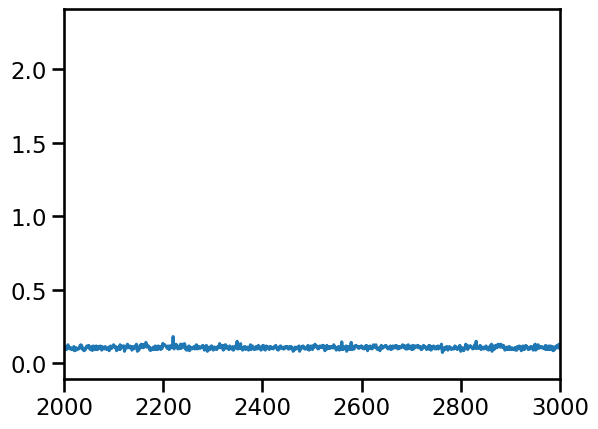

In [51]:
plt.plot(isi_df['isi'])
plt.xlim(2000, 3000)

In [52]:
isi_df

,Time,peaks,isi
0,1.001534e+07,1.0,NaN
1,1.001534e+07,1.0,0.128
2,1.001534e+07,1.0,0.100
3,1.001534e+07,1.0,0.108
4,1.001534e+07,1.0,0.120
...,...,...,...
15888,1.001746e+07,1.0,0.112
15889,1.001746e+07,1.0,0.116
15890,1.001746e+07,1.0,0.112
15891,1.001746e+07,1.0,0.120


In [53]:
trial_summary_isi = plotting.trial_collection(reward_sites[['has_choice', 'visit_number', 'odor_label', 'odor_sites', 'time_in_odor_site']], 
                                                    isi_df, mouse, session, 
                                                    window=(-2,8), taken_col='isi')


In [54]:
trial_summary_isi

,times,isi,has_choice,visit_number,odor_label,odor_sites,time_in_odor_site,mouse,session


In [55]:
#calculate isi
isi = np.diff(peak_times) 
len(isi), len(peak_times)

(15892, 15893)

In [56]:
#intersniff interval trial summary
trial_summary_isi= plotting.trial_collection(reward_sites[[ 'visit_number', 'odor_label','odor_sites']], encoder_data, mouse, session, window=(-2,4))

In [57]:
#same one for sniffing
#align to first peak for first 10 odor sites
#subtract odor onset time from peak times -- will always start at 0